# Double sky line masking in P1D

Masking sky lines in FFT estimates of P1D

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import input_power
import skewer_maker

Define the input power spectrum

In [3]:
input_p1d=input_power.InputPower(P0=10.0,k0=0.01,kF=0.1,r_SiIII=2271,f_SiIII=0.1)

Define the long FFT grid used to generate skewers

In [4]:
seed=1234
# whole range of FFT grid (larger than the length of a given skewer)
L_long=80000
N_long=2**11
dx_long=L_long/N_long
print('long',N_long,L_long,dx_long)
maker=skewer_maker.SkewerMaker(N=N_long,L=L_long,input_power=input_p1d,seed=seed)

long 2048 80000 39.0625


Define the survey window (skewers will only be visible here)

In [5]:
# the window will start at 0, but it doesn't matter (the skewers are periodic)
N_window=N_long//8
L_window=L_long*N_window/N_long
print('window',N_window,L_window,L_window/N_window)

window 256 10000.0 39.0625


In [6]:
# the FFT grid used in the analysis could be different than the window, since we might add zero padding
N=int(2*N_window)
L=L_window*N/N_window
# pixel width 
dx = L/N
print('analysis',N,L,dx)
# Wavenumbers for the generated Fourier modes, specified by the grid length and resolution
k = np.fft.fftfreq(N)*2*np.pi/dx
print('Delta k =',k[1],2*np.pi/L)
print('k_Ny = ',-k[N//2],np.pi/dx)
# Positions
x = dx*np.arange(N)
# evaluate input P1D in the analysis grid 
true_p1d=input_p1d.get_true_p1d(np.abs(k))

analysis 512 20000.0 39.0625
Delta k = 0.0003141592653589793 0.0003141592653589793
k_Ny =  0.0804247719318987 0.0804247719318987


### Double sky line masking  

In [7]:
# create a mask for this particular test
mask=np.zeros(N)
mask[:N_window]=1
# double sky line masking
mask[48:56]=0
mask[96:104]=0

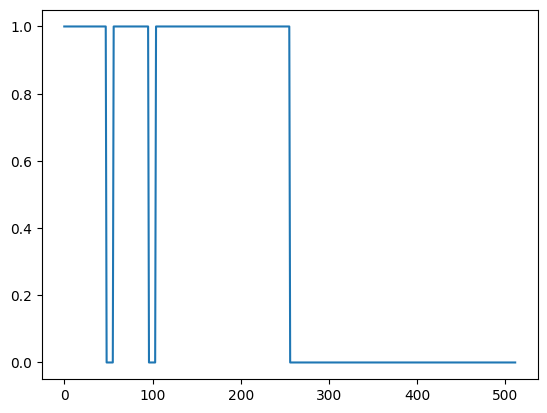

In [8]:
plt.plot(mask)

In [9]:
# number of skewers to make
Nsk=int(1e5)
savedir='sky_{}_{}_{}_L{}_{}/'.format(N_long,N_window,N,int(L),Nsk)
if os.path.isdir(savedir):
    print(savedir,'already exists, will override')
else:
    print('make new directory',savedir)
    os.mkdir(savedir)

sky_2048_256_512_L20000_100000/ already exists, will override


In [10]:
# reset seed again
maker.reset_seed()
# measure P1D and variance ( F_m = < |f_m|^2 >)
F_m=np.zeros(N)
var_F_m=np.zeros(N)
# mean of |w_m|^2 (FFT of mask, squared)
w2_m=np.zeros(N)
for i in tqdm(range(Nsk)):
    # FFT of mask
    w_m = np.fft.fft(mask)
    w2_m += abs(w_m)**2
    # generate random field 
    skewer=maker.make_skewer()
    # keep only those within window, in the FFT grid
    deltas = skewer[:N]
    deltas *= mask
    # and FFT again to obtain masked modes
    f_m=np.fft.fft(deltas)
    p1d = abs(f_m)**2
    F_m += p1d
    var_F_m += p1d**2
# normalize mask
w2_m /= Nsk    
# normalize them
F_m /= Nsk
var_F_m /= Nsk
var_F_m -= F_m**2
# correct normalisation based on my notes
mean_p1d = (dx/N) * F_m
err_p1d = (dx/N) * np.sqrt(var_F_m/Nsk)

100%|████████████████████████████| 100000/100000 [00:05<00:00, 18809.32it/s]


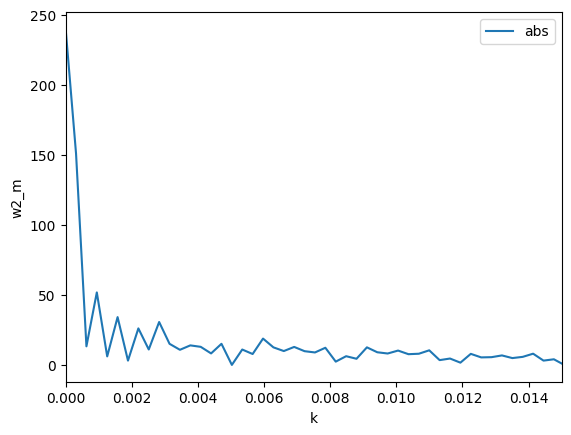

In [11]:
# plot FFT of mask (squared)
plt.plot(k[:N//2],np.sqrt(w2_m[:N//2]),label='abs')
plt.legend()
plt.xlabel('k')
plt.ylabel('w2_m')
plt.xlim([0,0.015])
plt.savefig(savedir+'/w2_m.pdf')

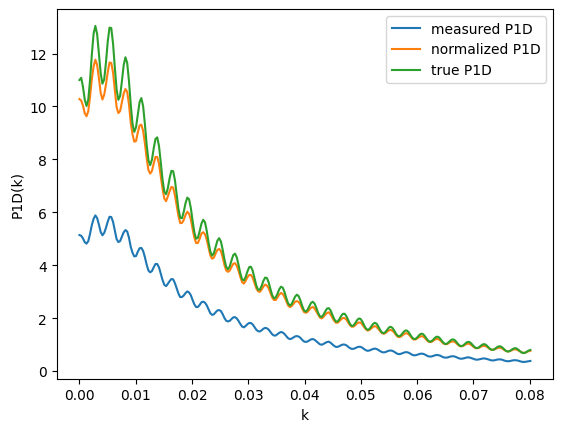

In [12]:
plt.plot(k[:N//2],mean_p1d[:N//2],label='measured P1D')
plt.plot(k[:N//2],N/N_window*mean_p1d[:N//2],label='normalized P1D')
plt.plot(k[:N//2],true_p1d[:N//2],label='true P1D')
plt.xlabel('k')
plt.ylabel('P1D(k)')
plt.legend()
plt.savefig(savedir+'/p1d.pdf')

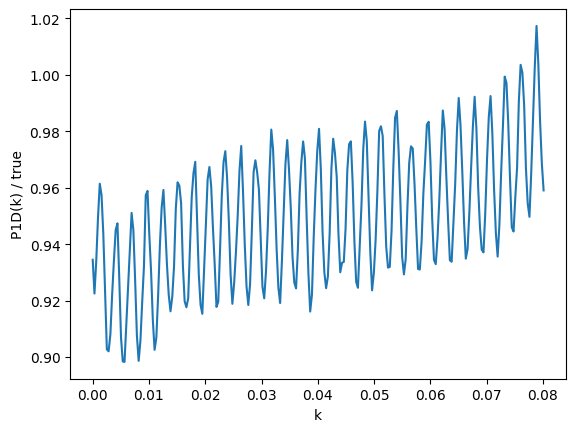

In [13]:
plt.plot(k[:N//2],N/N_window*mean_p1d[:N//2]/true_p1d[:N//2])
plt.xlabel('k')
plt.ylabel('P1D(k) / true')
#plt.legend()
plt.savefig(savedir+'/p1d_ratio.pdf')

### Try to convolve theory with mask

In [14]:
# use iFFT of P1D evaluated on the grid
P_m = true_p1d / dx # < |delta_m|^2 >    
xi_a = np.fft.ifft(P_m)
Q_a = np.fft.ifft(w2_m)

In [15]:
T_m = np.fft.fft(Q_a*xi_a)

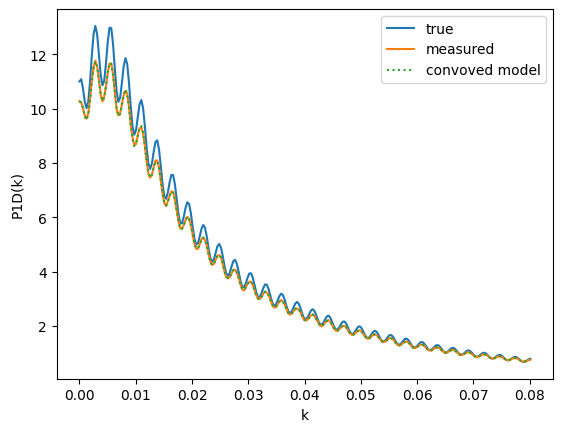

In [16]:
plt.plot(k[:N//2],true_p1d[:N//2],label='true')
plt.plot(k[:N//2],N/N_window*mean_p1d[:N//2],label='measured')
#plt.plot(k,convolved_p1d/N/N,ls=':',label='convolved')
plt.plot(k[:N//2],N/N_window*T_m[:N//2].real*(dx/N),ls=':',label='convoved model')
plt.xlabel('k')
plt.ylabel('P1D(k)')
plt.legend()
plt.savefig(savedir+'/p1d_convolved.pdf')

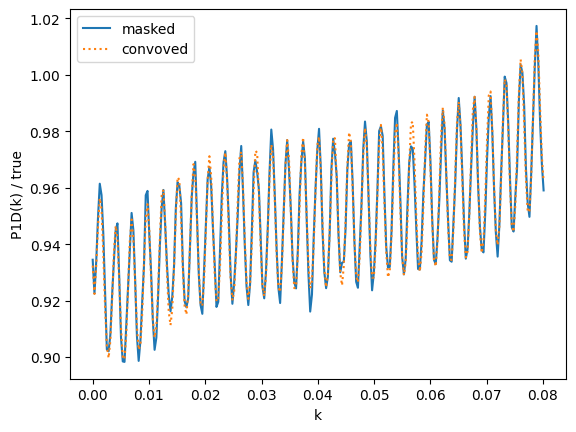

In [17]:
plt.plot(k[:N//2],N/N_window*mean_p1d[:N//2]/true_p1d[:N//2],label='masked')
plt.plot(k[:N//2],N/N_window*T_m[:N//2].real*(dx/N)/true_p1d[:N//2],ls=':',label='convoved')
plt.xlabel('k')
plt.ylabel('P1D(k) / true')
plt.legend()
plt.savefig(savedir+'/p1d_ratio_convolved.pdf')

### Rebin power

In [18]:
# we will use band powers defined by the grid of the forest (L/4)
dk_bin=2*np.pi/L_window
print('dk =',dk_bin)
# stop roughly at half the Nyquist frequency for now
k_max=np.pi/dx/2
print('k < ',k_max)
k_edges=np.arange(0.01*dk_bin,k_max+dk_bin,dk_bin)
Nk=k_edges.size-1
print('Nk =',Nk)

dk = 0.0006283185307179586
k <  0.04021238596594935
Nk = 64


In [19]:
# define the rebinning vector B_alpha_m in the notes (including negative frequencies!)
B_m=np.zeros([Nk,N])
for i in range(Nk):
    #print(i,k_edges[i],k_edges[i+1])
    inbin=(abs(k)>k_edges[i]) & (abs(k)<k_edges[i+1])
    B_m[i,inbin]=1    

In [20]:
# mean wavenumber in each bin
k_A=np.zeros(Nk)
for i in range(Nk):
    k_A[i]=np.sum(B_m[i]*abs(k))/np.sum(B_m[i])

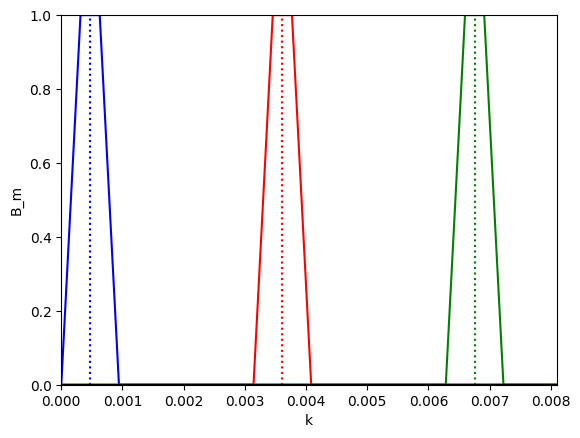

In [21]:
#plt.plot(k[:N//2],B_m[0][:N//2],label='k={:.3f}'.format(k_A[0]))
#plt.plot(k[:N//2],B_m[5][:N//2],label='k={:.3f}'.format(k_A[5]))
#plt.plot(k[:N//2],B_m[10][:N//2],label='k={:.3f}'.format(k_A[10]))
plt.plot(k[:N//2],B_m[0][:N//2],color='blue')
plt.axvline(x=k_A[0],color='blue',ls=':')
plt.plot(k[:N//2],B_m[5][:N//2],color='red')
plt.axvline(x=k_A[5],color='red',ls=':')
plt.plot(k[:N//2],B_m[10][:N//2],color='green')
plt.axvline(x=k_A[10],color='green',ls=':')
plt.axhline(y=0,color='black')

#plt.legend()
plt.xlim([0,1.2*k_A[10]])
plt.ylim([0,1])
plt.xlabel('k')
plt.ylabel('B_m')
plt.savefig(savedir+'B_m.pdf')

In [22]:
# iFFT B_m to get B_a (for the convolution theorem)
B_a=np.empty([Nk,N])
for i in range(Nk):
    B_a[i]=np.fft.ifft(B_m[i]).real

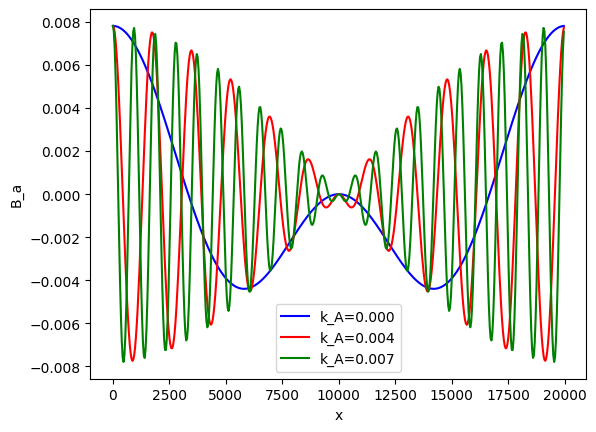

In [23]:
plt.plot(x,B_a[0],color='blue',label='k_A={:.3f}'.format(k_A[0]))
plt.plot(x,B_a[5],color='red',label='k_A={:.3f}'.format(k_A[5]))
plt.plot(x,B_a[10],color='green',label='k_A={:.3f}'.format(k_A[10]))
plt.xlabel('x')
plt.ylabel('B_a')
plt.legend()
plt.savefig(savedir+'B_a.pdf')

In [24]:
BQ_m=np.empty([Nk,N])
for i in range(Nk):
    BQ_m[i]=np.fft.fft(B_a[i]*Q_a).real

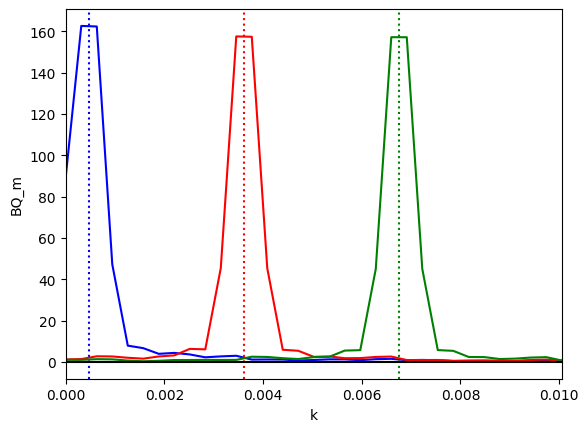

In [25]:
#plt.plot(k[:N//2],BQ_m[0][:N//2],label='k_A={:.3f}'.format(k_A[0]))
#plt.plot(k[:N//2],BQ_m[5][:N//2],label='k_A={:.3f}'.format(k_A[5]))
#plt.plot(k[:N//2],BQ_m[10][:N//2],label='k_A={:.3f}'.format(k_A[10]))

plt.plot(k[:N//2],BQ_m[0][:N//2],color='blue')
plt.axvline(x=k_A[0],color='blue',ls=':')
plt.plot(k[:N//2],BQ_m[5][:N//2],color='red')
plt.axvline(x=k_A[5],color='red',ls=':')
plt.plot(k[:N//2],BQ_m[10][:N//2],color='green')
plt.axvline(x=k_A[10],color='green',ls=':')
plt.axhline(y=0,color='black')

plt.xlim([0,k_max/4])
plt.xlabel('k')
plt.ylabel('BQ_m')
#plt.legend()
plt.savefig(savedir+'/BQ_m.pdf')

In [26]:
# normalisation (for this example, this is a constant)
A_A=np.empty(Nk)
for i in range(Nk):
    A_A[i]=np.sum(BQ_m[i])/dx

In [27]:
# actual summary statistics
Theta_A=np.zeros_like(A_A)
# convolved model
model_A=np.empty(Nk)
for i in range(Nk):
    Theta_A[i]=np.sum(B_m[i]*F_m)/A_A[i]
    model_A[i]=(np.sum(B_m[i]*T_m)/A_A[i]).real

In [28]:
true_p1d_A=input_p1d.get_true_p1d(k_A)

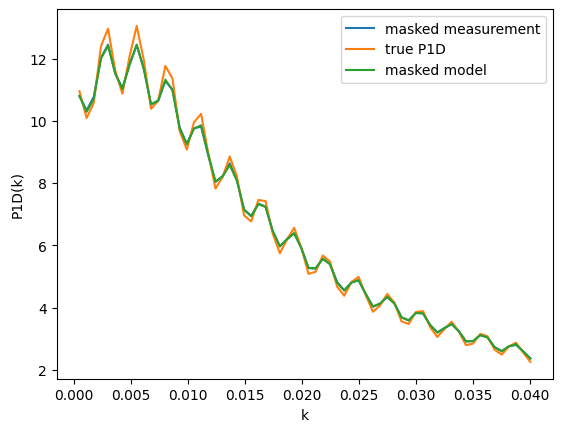

In [29]:
plt.plot(k_A,Theta_A,label='masked measurement')
plt.plot(k_A,true_p1d_A,label='true P1D')
plt.plot(k_A,model_A,label='masked model')
plt.xlabel('k')
plt.ylabel('P1D(k)')
plt.legend()
plt.savefig(savedir+'binned_p1d_convolved.pdf')

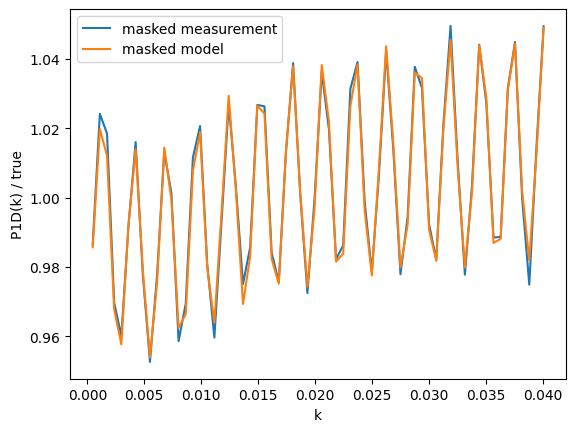

In [30]:
plt.plot(k_A,Theta_A/true_p1d_A,label='masked measurement')
plt.plot(k_A,model_A/true_p1d_A,label='masked model')
#plt.plot(k_A,get_true_p1d(k_A),label='true P1D')
plt.xlabel('k')
plt.ylabel('P1D(k) / true')
plt.legend()
plt.savefig(savedir+'binned_p1d_ratio_convolved.pdf')

In [31]:
# create a mask for zero padding only
pad_mask=np.zeros(N)
pad_mask[:N_window]=1
# create a mask for double sky line
sky_mask=np.ones(N)
sky_mask[48:56]=0
sky_mask[96:104]=0
# create a mask for both zero padding and double sky line
tot_mask=np.ones(N)
tot_mask[N_window:]=0
tot_mask[48:56]=0
tot_mask[96:104]=0

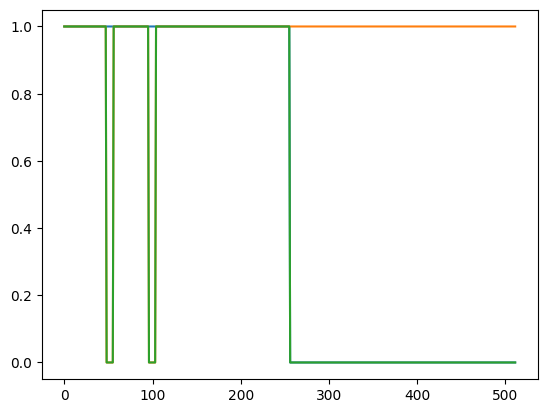

In [32]:
plt.plot(pad_mask)
plt.plot(sky_mask)
plt.plot(tot_mask)

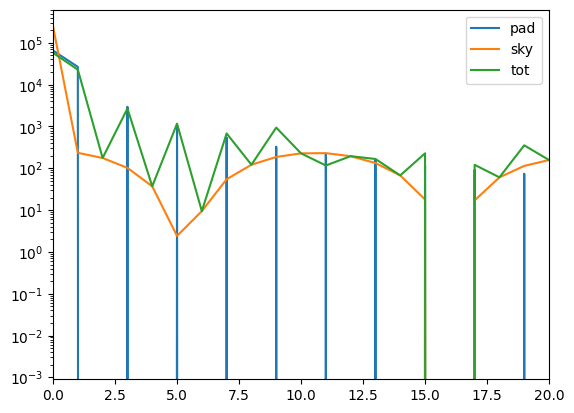

In [33]:
for tag,mask in zip(['pad','sky','tot'],[pad_mask,sky_mask,tot_mask]):
    # FFT of mask
    w_m = np.fft.fft(mask)
    w2_m = abs(w_m)**2
    plt.semilogy(w2_m,label=tag)
    plt.xlim([0,20])
plt.legend()